In [1]:
import numpy as np
import pmovestir as pmstir
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import LinearNDInterpolator
import pandas as pd
from scipy.stats import gaussian_kde
import importlib
import itertools
from scipy.spatial import ConvexHull
import shapely.geometry as geometry
from shapely import intersection
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = 'Arial'

# Notebook to reproduce Fig. 4 and Fig. 5 in the manuscript relating to deer movements

In [2]:
def trim_movement_data(dat):
    """
    Trim the movement data by the first 15 days after capture and remove the
    last two days
    """

    # Trim the movement 
    host_ids = dat.animal_id.unique()

    sorted_hosts = []
    for hid in host_ids:
        
        # Remove approximately the first 15 days and the last 2 days
        tdat = (dat.query("animal_id == {0}".format(hid))
                        .sort_values(by="t_").iloc[48*15:-48*2, :]
                        .assign(datetime = lambda x: pd.to_datetime(x.t_))
                        .assign(year = lambda x: x.datetime.dt.year)
                        .assign(unix_time = lambda x: x.datetime.astype(np.int64) / (60 * 10**9)) # Convert nanoseconds to mintues
                        .rename(columns={'x_': 'UTMx', 'y_': 'UTMy', 
                                         'animal_id': "individual_ID"}))
        
        sorted_hosts.append(tdat)

    # Removing the first 15 days removes 13 animals
    trun_dat = pd.concat(sorted_hosts)
    trun_dat.individual_ID.unique().shape
    return(trun_dat)


def get_combos_for_correlation(trun_dat, minutes=30):
    """
    Get the host combinations needed to compute the correlations
    """

    # Get combinations that we can loop through
    all_host_ids = trun_dat.individual_ID.unique()
    combos = list(itertools.combinations(all_host_ids, 2))

    deer_dat = trun_dat[['individual_ID', 'datetime', 'unix_time', 'UTMx', 'UTMy', 'year']]
    trajs = pmstir.interpolate_all_trajectories(minutes, deer_dat)

    # Restrict to combinations where we have some temporal and spatial
    # overlap
    keep_combos = []
    for combo in combos:

        h1 = trajs[combo[0]]
        h2 = trajs[combo[1]]

        # Check spatial and temporal overlap
        values = ['time', 'x', 'y']

        overlap_bools = []
        for val in values:
            min1 = h1[val].min()
            max1 = h1[val].max()
            min2 = h2[val].min()
            max2 = h2[val].max()
            no_overlap = (min1 > max2) or (min2 > max1)
            overlap_bools.append(not no_overlap)

        if np.all(overlap_bools):
            keep_combos.append(combo)

    return((keep_combos, trajs))


def get_correlation_surface(host1, host2, X, Y, grid_size, num_per_split=150, shifts=5):
    """
    Pass in aligned trajectories and an X, Y gridded surface and get the
    correlation surface

    Parameters
    ----------
    host1 : dataframe
    host2 : dataframe
    X : np.array
    Y : np.array
    grid_size : float
        The grid size of the landscape
    num_per_split : int
        Default is 150.  Do this in splits to avoid memory issues
    shifts : int
        Number of shifts of the grid cells to calculate the split
    """
    
    # Depending on where you put the grid bounds, you can get slightly
    # different answer.  Compute this multiple times using a sliding
    # window and then average.
    shifts = np.linspace(0, 1, num=shifts)
    all_cor = np.empty((len(shifts), len(X.ravel())))
    
    for j, shift in enumerate(shifts):
        
        flatX_lower = X.ravel() - shift*grid_size
        flatX_upper = X.ravel() + (1 - shift)*grid_size
        flatY_lower = Y.ravel() - shift*grid_size
        flatY_upper = Y.ravel() + (1 - shift)*grid_size
    
        host1_xlocs = host1.x.values
        host1_ylocs = host1.y.values
    
        host2_xlocs = host2.x.values
        host2_ylocs = host2.y.values
    
        # Break this into chunks for memory issues
        inds = np.arange(len(flatX_lower))
    
        n = np.ceil(len(flatX_lower) / num_per_split)
        splits = np.array_split(inds, n)    
    
        cor_res = []
        pvalues = []
    
        # Compute across different splits
        for s in splits:
    
            flatX = (flatX_lower[s], flatX_upper[s])
            flatY = (flatY_lower[s], flatY_upper[s])
            tcor = pmstir.matrix_correlation(host1, host2, flatX, flatY)
            df = host1.shape[0] - 2
            tval = tcor / np.sqrt((1 - tcor**2) / df)
            pvalue = 2*(1 - stats.t.cdf(np.abs(tval), df))
            cor_res.append(tcor)
            pvalues.append(pvalue)
    
        cor12 = np.concatenate(cor_res)
        pvalue12 = np.concatenate(pvalues)
    
        # Use a bonferonni correction to remove apparent correlations
        p_correction = 1 #0.001 / len(pvalue12)
        no_sig_cor = pvalue12 > p_correction
        cor12[no_sig_cor] = 0
        all_cor[j, :] = cor12
    
    # Average over different shifts
    cor12 = np.nanmean(all_cor, axis=0)
    
    # Reformat as a matrix
    C12 = cor12.reshape(X.shape)
    
    return(C12)

def area_of_mcp_overlap(host1, host2):
    """
    Compuate the area of the MCP overlap
    """

    polygons = []
    hosts = [host1, host2]
    
    for host in hosts:
    
        locs = host[['x', 'y']].values
        hull = ConvexHull(locs)
        x = locs[hull.vertices, 0]
        y = locs[hull.vertices, 1]    
        poly = geometry.Polygon(zip(x, y))
        polygons.append(poly)

    return(intersection(polygons[0], polygons[1]).area)

# Figure 4B-C: Compute the Average CSR for female-female and male-male pairs

In [7]:
# 1. Load data
filename = "../data/cleaned_movement_data_08292024.csv" # Note that given ongoing analyses, we do not provide the full movement data at this time
dat = pd.read_csv(filename)
dat = dat.query("fast_step_ == False and fast_roundtrip_ == False")
trun_dat = trim_movement_data(dat)
keep_combos, trajs = get_combos_for_correlation(trun_dat, minutes=10)

In [6]:
# 2. Get seasonal information
seasons_map = {1: "Rut", 2: "Gestation", 3: "Gestation", 4: "Gestation", 5: "Gestation",
               6: "Fawning", 7: "Fawning", 8: "Lactation",
               9: "Lactation", 10: "Lactation", 11: "Rut", 12: "Rut"}

deer_trajs = (pd.concat(trajs)
                .reset_index()
                .drop(columns="level_1")
                .rename(columns={"level_0": "individual_ID"})
                .assign(datetime=lambda x: pd.to_datetime(x.time*60, unit="s"))
                .assign(month=lambda x: x.datetime.dt.month, 
                        year=lambda x: x.datetime.dt.year)
                .assign(season=lambda x: x.month.map(seasons_map))
                .assign(year_season=lambda x: x.year.astype(np.str_) + "_" + x.season))

In [8]:
# Adjust wrapping of the Rut season
deer_trajs.loc[deer_trajs.year_season == "2024_Rut", "year_season"] = "2023_Rut"

# Parameters
grid_size = 40 # Length of side of grid cell for area of transmission
interval = (5, 95) # Only calculate correlation surface in some area
foi_results = []
randomize = 201 # Number of randomizations. The first one is no randomization

# 151571-151589: Female-female pair; 155135-155141: Male-male pair
keep_combos =  [(151571, 151589), (155135, 155141)]

for nc, combo in enumerate(keep_combos[:]):

    host1_dat = deer_trajs.query("individual_ID == {0}".format(combo[0]))
    host2_dat = deer_trajs.query("individual_ID == {0}".format(combo[1]))

    # Get year gestation combos that are shared
    unq_year_gestation_combos = np.intersect1d(host1_dat.year_season.unique(), 
                                               host2_dat.year_season.unique())

    # Loop through unique season and year combinations, recognizing
    # that correlation can be very dynamic!
    for yg in unq_year_gestation_combos:
        
        print(combo, yg)
        d1 = host1_dat.query("year_season == '{0}'".format(yg))
        d2 = host2_dat.query("year_season == '{0}'".format(yg))

        # Align trajectories
        host1, host2 = pmstir.align_trajectories(d1.reset_index(drop=True), 
                                                 d2.reset_index(drop=True))

        for r in range(randomize):

            if r % 10 == 0:
                print(r)
            
            if r != 0:
                thost1 = pmstir.randomize_day(host1)
                thost2 = pmstir.randomize_day(host2)
                type_of_val = "random"
            else:
                thost1 = host1
                thost2 = host2
                type_of_val = "observed"
    
            # Check on spatial overlap
            if r == 0:
                area_overlap = area_of_mcp_overlap(host1, host2)
    
            # Compute direct contacts
            direct_distance = np.array([pmstir.distance(p1, p2) for p1, p2 in 
                                        zip(thost1[['x', 'y']].values, 
                                            thost2[['x', 'y']].values)])
            dcontact = (direct_distance < grid_size).astype(np.int64)
            contact_df = thost1[['x', 'y']].assign(contact=dcontact).query("contact == True")
            num_contacts = np.sum(dcontact == 1)
                
            host1_lowerx, host1_upperx = stats.scoreatpercentile(thost1.x.values, interval)
            host1_lowery, host1_uppery = stats.scoreatpercentile(thost1.y.values, interval)
            host2_lowerx, host2_upperx = stats.scoreatpercentile(thost2.x.values, interval)
            host2_lowery, host2_uppery = stats.scoreatpercentile(thost2.y.values, interval)
            
            xmin = np.min(np.r_[host1_lowerx, host2_lowerx])
            xmax = np.max(np.r_[host1_upperx, host2_upperx])
            ymin = np.min(np.r_[host1_lowery, host2_lowery])
            ymax = np.max(np.r_[host1_uppery, host2_uppery])
            
            # Consider these midpoints of grids
            xvals = np.arange(xmin, xmax + grid_size, step=grid_size)
            yvals = np.arange(ymin, ymax + grid_size, step=grid_size)
            X, Y = np.meshgrid(xvals, yvals)
    
            # Compute the correlation surface
            C12 = get_correlation_surface(thost1, thost2, X, Y, grid_size, num_per_split=150, shifts=5)
    
            # Calculate the UDs of hosts....just do this once
            if r == 0:
                positions = np.vstack([X.ravel(), Y.ravel()])
                
                host1_locs = thost1[['x', 'y']].values.T
                kde1 = gaussian_kde(host1_locs[:, ::10])
                Z1 = np.reshape(kde1(positions).T, X.shape)*grid_size*grid_size
                
                host2_locs = thost2[['x', 'y']].values.T
                kde2 = gaussian_kde(host2_locs[:, ::10])
                Z2 = np.reshape(kde2(positions).T, X.shape)*grid_size*grid_size
                
                spaceuse_component = Z1*Z2
                bcoef_std = np.sum(np.sqrt((Z1 / np.sum(Z1)) * (Z2 / np.sum(Z2))))
                sd_component = np.sqrt(Z1*(1 - Z1))*np.sqrt(Z2*(1 - Z2))
            
            cor_component = C12
    
            mask = np.copy(cor_component)
            mask[~np.isnan(mask)] = 1
            only_space_use_foi = spaceuse_component*mask
            mean_space_use_foi = np.nanmean(only_space_use_foi)
            mean_total_foi = np.nanmean(sd_component*cor_component + only_space_use_foi)
            mean_cor_foi = np.nanmean(sd_component*cor_component)
            
            foi_results.append([str(combo), yg, bcoef_std, area_overlap, mean_cor_foi, 
                                mean_space_use_foi, num_contacts, host1_locs.shape[1], type_of_val])
            

(151571, 151589) 2023_Fawning
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
(151571, 151589) 2023_Gestation
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
(151571, 151589) 2023_Lactation
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
(151571, 151589) 2023_Rut
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
(151571, 151589) 2024_Gestation
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
(155135, 155141) 2024_Fawning
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
(155135, 155141) 2024_Gestation
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
(155135, 155141) 2024_Lactation
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [9]:
# Convert to a dataframe for plotting
foi_results_df = pd.DataFrame(foi_results, columns=['pair', 'year_season', 'BC', 'area_overlap_m2', 'foi_cor', 'foi_space', 
                                                    'num_contacts', 'num_locs', 'type_of_val'])
foi_results_df = foi_results_df.assign(log_foi_ratio = lambda x: np.log(np.abs(x.foi_cor) / x. foi_space))

(151571, 151589)
(155135, 155141)


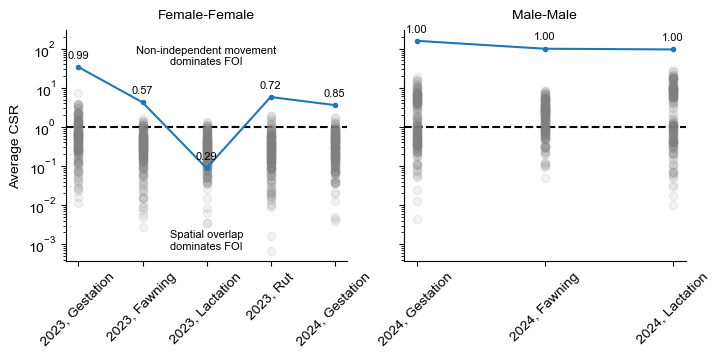

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

orders = [["2023_Gestation", "2023_Fawning", "2023_Lactation", "2023_Rut", "2024_Gestation"],
          ["2024_Gestation", "2024_Fawning", "2024_Lactation"],
          ["2024_Gestation", "2024_Fawning", "2024_Lactation"]]

plot_title = ['Female-Female', 'Male-Male']
#orders = ["2023np.arange(1, 13)]

pairs = foi_results_df.pair.unique()
for i, p in enumerate(pairs):
    print(p)

    tdat = foi_results_df[foi_results_df.pair == p]
    year_season_unq = tdat.year_season.unique()

    tx = []
    ty = []
    for j, ys in enumerate(orders[i]):
        
        ttdat = tdat[tdat.year_season == ys]
        obs = ttdat[ttdat.type_of_val == "observed"].log_foi_ratio.values[0]
        bc = ttdat[ttdat.type_of_val == "observed"].BC.values[0]
        rand = ttdat[ttdat.type_of_val == "random"].log_foi_ratio.values

        tx.append(j)
        ty.append(obs)
        axes[i].semilogy(np.repeat(j, len(rand)), np.exp(rand), 'o', color='gray', alpha=0.1, zorder=-1)
        #axes[i].violinplot(np.exp(rand), posi=[j])
        #axes[i].boxplot(np.exp(rand), positions=[j])
        axes[i].text(j, np.exp(obs + 0.5), "{0:.2f}".format(bc), size=8, ha="center")

    axes[i].semilogy(tx, np.exp(ty), '-o', ms=3)
    axes[i].set_xticks(np.arange(len(orders[i])))
    axes[i].set_xticklabels([", ".join(o.split("_")) for o in orders[i]], rotation=45)
    axes[i].text(0.5, 1.05, plot_title[i], ha='center', transform=axes[i].transAxes)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    xlim = axes[i].get_xlim()
    axes[i].hlines(1, *xlim, color='black', linestyle='--', zorder=-10)
    axes[i].set_xlim(*xlim)

    if i == 0:
        axes[i].set_ylabel("Average CSR(x)")
    if i == 0:
        axes[i].text(0.5, 0.05, "Spatial overlap\ndominates FOI", ha='center', size=8, transform=axes[i].transAxes)
        axes[i].text(0.5, 0.85, "Non-independent movement\ndominates FOI", size=8, ha='center', transform=axes[i].transAxes)

fig.savefig("../results/seasonal_csr.pdf", bbox_inches="tight")
    

## Fig. 5: Visualize landscape-level correlation

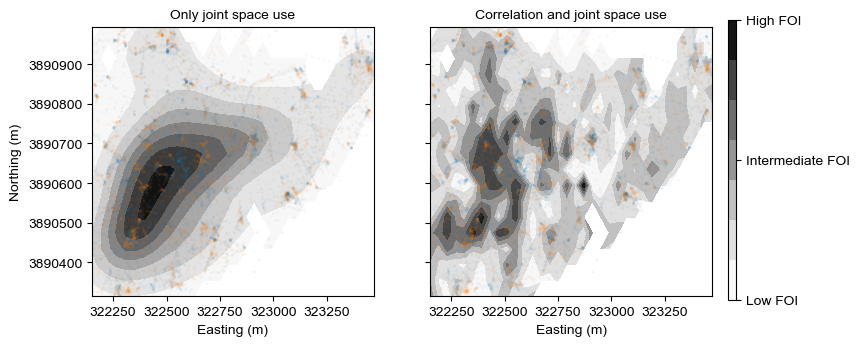

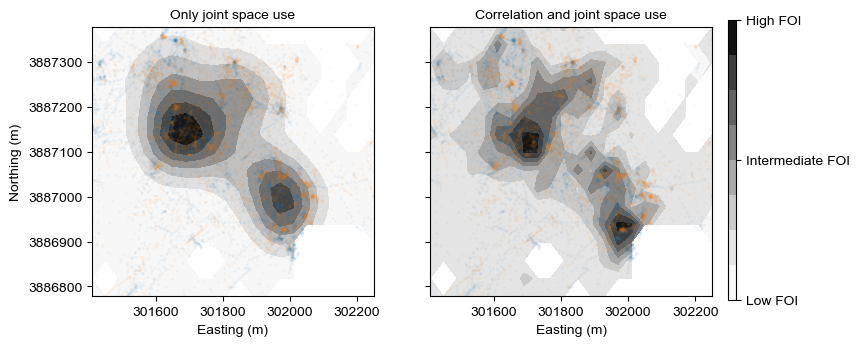

In [3]:
# Load and set-up the deer data
full_deer_ids = [[155135, 155141], [151571, 151589]]
season = "Gestation"
year_ids = [2024, 2023]

for d, deer_ids in enumerate(full_deer_ids):
    
    year = year_ids[d]
    
    filename = "../data/cleaned_movement_data_08292024.csv"
    dat = pd.read_csv(filename)
    dat = dat.query("fast_step_ == False and fast_roundtrip_ == False")
    deer_dat = trim_movement_data(dat)
    # deer_dat = deer_dat[deer_dat.individual_ID.isin(deer_ids)]
    
    deer_dat = deer_dat[['individual_ID', 'datetime', 'unix_time', 'UTMx', 'UTMy', 'year']]
    trajs = pmstir.interpolate_all_trajectories(10, deer_dat)
    
    seasons_map = {1: "Rut", 2: "Gestation", 3: "Gestation", 4: "Gestation", 5: "Gestation",
                   6: "Fawning", 7: "Fawning", 8: "Lactation",
                   9: "Lactation", 10: "Lactation", 11: "Rut", 12: "Rut"}
    deer_trajs = (pd.concat(trajs)
                    .reset_index()
                    .drop(columns="level_1")
                    .rename(columns={"level_0": "individual_ID"})
                    .assign(datetime=lambda x: pd.to_datetime(x.time*60, unit="s"))
                    .assign(month=lambda x: x.datetime.dt.month, 
                            year=lambda x: x.datetime.dt.year)
                    .assign(season=lambda x: x.month.map(seasons_map))
                    .assign(year_season=lambda x: x.year.astype(np.str_) + "_" + x.season))
    
    # Adjust wrapping of the Rut season...this works for now...but does not generalize
    deer_trajs.loc[deer_trajs.year_season == "2024_Rut", "year_season"] = "2023_Rut"
    
    d1 = deer_trajs.query("individual_ID == {0} and season == '{1}' and year == {2}".format(deer_ids[0], season, year))
    d2 = deer_trajs.query("individual_ID == {0} and season == '{1}' and year == {2}".format(deer_ids[1], season, year))
    
    host1, host2 = pmstir.align_trajectories(d1.reset_index(drop=True), 
                                             d2.reset_index(drop=True))
    
    ### Step 1. Begin the correlation analysis ###
    
    # Specify the grid on which to calculate correlation
    grid_size = 40
    interval = (5, 95)
    host1_lowerx, host1_upperx = stats.scoreatpercentile(host1.x.values, interval)
    host1_lowery, host1_uppery = stats.scoreatpercentile(host1.y.values, interval)
    host2_lowerx, host2_upperx = stats.scoreatpercentile(host2.x.values, interval)
    host2_lowery, host2_uppery = stats.scoreatpercentile(host2.y.values, interval)
    
    xmin = np.min(np.r_[host1_lowerx, host2_lowerx])
    xmax = np.max(np.r_[host1_upperx, host2_upperx])
    ymin = np.min(np.r_[host1_lowery, host2_lowery])
    ymax = np.max(np.r_[host1_uppery, host2_uppery])
    
    # Consider these midpoints of grids
    xvals = np.arange(xmin, xmax + grid_size, step=grid_size)
    yvals = np.arange(ymin, ymax + grid_size, step=grid_size)
    X, Y = np.meshgrid(xvals, yvals)
    
    # Get the correlation surface
    C12 = get_correlation_surface(host1, host2, X, Y, grid_size)
    
    # Plot for visualization
    # plt.pcolormesh(X, Y, C12, shading="auto")
    # plt.colorbar()
    
    ### COMPUTE the UDs for each host on the same grid as above ###
    
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    host1_locs = host1[['x', 'y']].values.T
    kde1 = gaussian_kde(host1_locs[:, ::10])
    Z1 = np.reshape(kde1(positions).T, X.shape)*grid_size*grid_size
    
    host2_locs = host2[['x', 'y']].values.T
    kde2 = gaussian_kde(host2_locs[:, ::10])
    Z2 = np.reshape(kde2(positions).T, X.shape)*grid_size*grid_size
    
    spaceuse_component = Z1*Z2
    sd_component = np.sqrt(Z1*(1 - Z1))*np.sqrt(Z2*(1 - Z2))
    cor_component = C12
    
    mask = np.copy(cor_component)
    mask[~np.isnan(mask)] = 1
    only_space_use_foi = spaceuse_component*mask
    mean_space_use_foi = np.nanmean(only_space_use_foi)
    mean_total_foi = np.nanmean(sd_component*cor_component + only_space_use_foi)
    mean_cor_foi = np.nanmean(sd_component*cor_component)
    
    ### PLOT THE SURFACES ###
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True)
    
    
    alpha = 0.05
    cmap = "Greys"
    axes[0].contourf(X, Y, only_space_use_foi, cmap="Greys")
    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()
    axes[0].plot(host1.x, host1.y, 'o', alpha=alpha, ms=2, mew=0)
    axes[0].plot(host2.x, host2.y, 'o', alpha=alpha, ms=2, mew=0)
    #axes[0].contour(X, Y, Z1, alpha=0.5,  cmap="Blues")
    #axes[0].contour(X, Y, Z2, alpha=0.5, cmap="Oranges")

    cb = axes[1].contourf(X, Y, only_space_use_foi + sd_component*cor_component, cmap="Greys")
    #axes[1].pcolormesh(X, Y, only_space_use_foi + sd_component*cor_component, shading="auto", cmap="Greys")
    axes[1].plot(host1.x, host1.y, 'o', alpha=alpha, ms=2, mew=0)
    axes[1].plot(host2.x, host2.y, 'o', alpha=alpha, ms=2, mew=0)

    cax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
    cbar = fig.colorbar(cb, cax=cax, orientation='vertical')
    ticks = cbar.get_ticks()
    cbar.set_ticks([np.min(ticks), np.mean(ticks), np.max(ticks)])
    cbar.set_ticklabels(["Low FOI", "Intermediate FOI", "High FOI"])
    
    titles = ["Only joint space use", "Correlation and joint space use"]
    letters = ["A.", "B."]
    for i, ax in enumerate(axes):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_title(titles[i], size=10)
        ax.set_xlabel("Easting (m)")
        if i == 0:
            ax.set_ylabel("Northing (m)")
        ax.ticklabel_format(style='plain')
        ax.ticklabel_format(useOffset=False)
        #ax.tick_params(bottom=None, labelbottom=None, left=None, labelleft=None)
        #ax.text(0, 1.02, letters[i], size=11, ha='center', transform=ax.transAxes)
    
        # Equalize both sides if desired
        # xrange = xlim[1] - xlim[0]
        # yrange = ylim[1] - ylim[0]
        # both_coords = np.array([xlim, ylim])
        # both_range = np.array([xrange, yrange])
        # max_ind = np.argmax(both_range)
        # min_ind = np.argmin(both_range)
        # diff = both_range[max_ind] - both_range[min_ind]
        # min_coords = (both_coords[min_ind][0] - diff / 2., both_coords[min_ind][1] + diff / 2.)
        # both_coords[i] = min_coords
        # ax.set_xlim(*both_coords[0])
        # ax.set_ylim(*both_coords[1])
    
    fig.savefig("../results/{0}_{1}_epi_landscape_{2}_{3}.pdf".format(deer_ids[0], deer_ids[1], year, season), dpi=300, bbox_inches="tight")


In [24]:
xmax

np.float64(nan)

# Does correlation actually reshape the spatial transmission risk?  

Perform randomized rank test to compare the landscapes.

In [29]:
# Parameters
grid_size = 40 # Length of side of grid cell for area of transmission
interval = (5, 95) # Only calculate correlation surface in some area
H_results = []
randomize = 1001
unq_year_gestation_combos = ["2023_Gestation", "2024_Gestation"] #
keep_combos = [(151571, 151589), (155135, 155141)]

for nc, combo in enumerate(keep_combos[:]):

    host1_dat = deer_trajs.query("individual_ID == {0}".format(combo[0]))
    host2_dat = deer_trajs.query("individual_ID == {0}".format(combo[1]))

    yg = unq_year_gestation_combos[nc]
    
    print(combo, yg)
    
    d1 = host1_dat.query("year_season == '{0}'".format(yg))
    d2 = host2_dat.query("year_season == '{0}'".format(yg))

    # Align trajectories
    host1, host2 = pmstir.align_trajectories(d1.reset_index(drop=True), 
                                             d2.reset_index(drop=True))

    for r in range(randomize):

        if r % 10 == 0:
            print(r)
        
        if r != 0:
            thost1 = pmstir.randomize_day(host1)
            thost2 = pmstir.randomize_day(host2)
            type_of_val = "random"
        else:
            thost1 = host1
            thost2 = host2
            type_of_val = "observed"

        # Set-up grids            
        host1_lowerx, host1_upperx = stats.scoreatpercentile(thost1.x.values, interval)
        host1_lowery, host1_uppery = stats.scoreatpercentile(thost1.y.values, interval)
        host2_lowerx, host2_upperx = stats.scoreatpercentile(thost2.x.values, interval)
        host2_lowery, host2_uppery = stats.scoreatpercentile(thost2.y.values, interval)
        
        xmin = np.min(np.r_[host1_lowerx, host2_lowerx])
        xmax = np.max(np.r_[host1_upperx, host2_upperx])
        ymin = np.min(np.r_[host1_lowery, host2_lowery])
        ymax = np.max(np.r_[host1_uppery, host2_uppery])
        
        # Consider these midpoints of grids
        xvals = np.arange(xmin, xmax + grid_size, step=grid_size)
        yvals = np.arange(ymin, ymax + grid_size, step=grid_size)
        X, Y = np.meshgrid(xvals, yvals)

        # Compute the correlation surface
        C12 = get_correlation_surface(thost1, thost2, X, Y, grid_size, num_per_split=150, shifts=5)

        # Calculate the UDs of hosts....just do this once
        if r == 0:
            positions = np.vstack([X.ravel(), Y.ravel()])
            
            host1_locs = thost1[['x', 'y']].values.T
            kde1 = gaussian_kde(host1_locs[:, ::10])
            Z1 = np.reshape(kde1(positions).T, X.shape)*grid_size*grid_size
            
            host2_locs = thost2[['x', 'y']].values.T
            kde2 = gaussian_kde(host2_locs[:, ::10])
            Z2 = np.reshape(kde2(positions).T, X.shape)*grid_size*grid_size
            
            spaceuse_component = Z1*Z2
            bcoef_std = np.sum(np.sqrt((Z1 / np.sum(Z1)) * (Z2 / np.sum(Z2))))
            sd_component = np.sqrt(Z1*(1 - Z1))*np.sqrt(Z2*(1 - Z2))
        
        cor_component = C12

        mask = np.copy(cor_component)
        mask[~np.isnan(mask)] = 1
        only_space_use_foi = spaceuse_component*mask

        # Compute the rank 
        compare_foi = (pd.DataFrame({'space_use_foi': only_space_use_foi.ravel(), 
                        'total_foi': only_space_use_foi.ravel() + (sd_component*cor_component).ravel()})
                         .dropna())
        H = stats.kruskal(compare_foi.space_use_foi, compare_foi.total_foi).statistic
        H_results.append([combo, yg, H, type_of_val])

(151571, 151589) 2023_Gestation
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
(155135, 155141) 2024_Gestation
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


In [30]:
H_results_df = pd.DataFrame(H_results, columns=['pair', 'year_season', 'H', 'type_of_val'])

(151571, 151589) p-value is 0.020000000000000018
(155135, 155141) p-value is 0.0


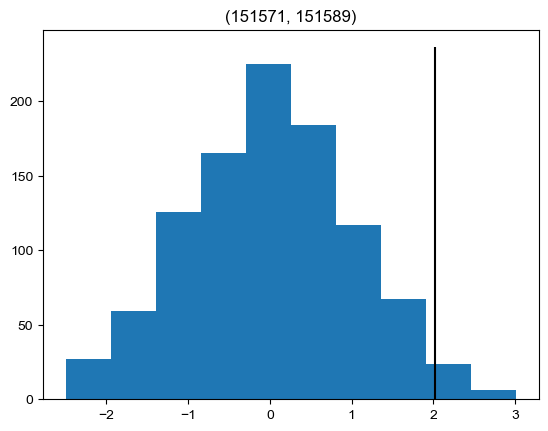

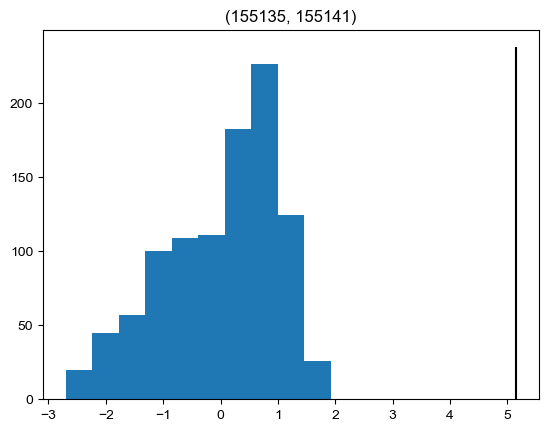

In [36]:
# Examine whether there is evidence of restructuring

for pid in keep_combos:
    
    obs = H_results_df[(H_results_df.pair == pid) & (H_results_df.type_of_val == "observed")].H.values[0]
    random = H_results_df[(H_results_df.pair == pid) & (H_results_df.type_of_val == "random")].H.values
    random_z = (random - np.mean(random)) / np.std(random)
    obs_z = (obs - np.mean(random)) / np.std(random)
    
    fig, ax = plt.subplots(1, 1)
    ax.hist(random_z)
    ylim = plt.ylim()
    ax.vlines(obs_z, *ylim, color='black')
    ax.set_title(pid)
    print(pid, "p-value is {0}".format((1 - np.mean(obs > random))))


## Figure 4A:  Examine the CSR ratio across seasons

Run the script `generate_foi_comparison_direct.py` to make the file `cor_contributions_grid_size_40.csv`

In [45]:
cor_dat = pd.read_csv("../results/cor_contributions_grid_size_40.csv")

In [46]:
cor_dat.shape

(388, 8)

In [47]:
cor_dat.pair.unique().shape

(254,)

In [48]:
cor_dat = cor_dat.assign(log_ratio = np.log10(np.abs(cor_dat.foi_cor) / np.abs(cor_dat.foi_space)))

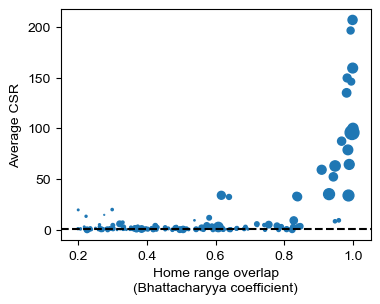

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ind = (cor_dat.BC >= 0.2) & (cor_dat.num_locs > 1000)
ax.scatter(cor_dat[ind].BC, 10**(cor_dat[ind].log_ratio), marker='o', 
           s=np.sqrt(8e9*cor_dat[ind].num_contacts / (cor_dat[ind].area_overlap_m2 * cor_dat[ind].num_locs)))
ax.hlines(1, 0.15, 1.05, color='black', linestyle='dashed')
ax.set_ylabel("Average CSR(x)")
ax.set_xlabel("Home range overlap\n(Bhattacharyya coefficient)")
ax.set_xlim(0.15, 1.05)

for i in range(cor_dat[ind].shape[0]):
    pt = cor_dat[ind].iloc[i, :]
    label = str(tuple([str(x) for x in eval(pt.pair)])) + "_" +  pt.year_season
    #ax.text(pt.BC, np.exp(pt.log_ratio), label, size=8, ha='center')

fig.savefig("../results/average_csr_all_deer.pdf", bbox_inches="tight")